# **Microproyecto 1**
## **Generación de paleta de colores a partir de imágenes con técnicas de machine learning no supervisado**
Una paleta de colores es un conjunto de tonos que se utilizan juntos para crear un efecto armonioso, coherente y atractivo en las representaciones visuales (diseño gráfico, cine, fotografía, pintura, etc.), así como para transmitir mensajes y generar emociones determinados, de acuerdo con la intencionalidad del autor de la obra.

En un contexto de amplia demanda de herramientas que puedan asistir a diseñadores gráficos, directores de arte, pintores y creadores de contenido, entre otros, para la selección rápida y adecuada de los colores apropiados para sus obras, una aplicación para configurar paletas de colores a partir de imágenes sería de mucha utilidad. 

El problema central radica en desarrollar un método automatizado que pueda generar una paleta coherente y estéticamente atractiva partiendo de los colores identificados en una imagen. Esto implica no solo reconocer tonos dominantes, sino también comprender la relación existente al interior de la gama cromática empleada para crear combinaciones visuales agradables y funcionales. Abordar este problema se traduciría en varias ventajas:

Eficiencia en el proceso creativo, al liberar tiempo que los autores podrían emplear en otros aspectos estratégicos de sus proyectos.

Consistencia interna en los diseños, manteniendo una identidad visual constante en diferentes aplicaciones y proyectos.

Facilidad de uso y recurso de aprendizaje para personas con menos experiencia en diseño, fomentando la creatividad en diversos campos.

Optimización de la calidad y del impacto de la comunicación visual. 

Una vía para lograr una herramienta como esta es utilizar técnicas de machine learning no supervisado sobre imágenes para visualizar la distribución de los colores dominantes presentes en estas y generar, de manera automática, modelos de paletas de colores. En esta primera aproximación el método va a permitir identificar los colores dominantes en una imagen para construir un muestrario por similitud de píxeles, lo cual puede ser muy útil para estudios de marketing, psicología, medicina, arte, ambiente, entre otros. Por ejemplo, se podrían extraer los colores de las diferentes superficies de la Tierra en una imagen satelital para estudiar la distribución de la vegetación o de la contaminación.
### **A. Objetivo**

Desarrollar un método, basado en técnicas de agrupación, que permita extraer los tonos dominantes de una imagen y generar un muestrario de los colores representativos presentes en esta. 

### **B. Conjunto de datos**

Los datos están asociados con imágenes de obras de arte. Pueden ser descargados a partir de este
 enlace <a href="https://www.kaggle.com/datasets/steubk/wikiart" target="_blank">WikiArt</a>.
### **C. Actividades para realizar**

1. Recopilación de las imágenes a partir del repositorio. La idea es seleccionar un conjunto diverso de muestras en diferentes estilos artísticos (varios pintores). Se recomienda seleccionar entre 6 y 10 imágenes.

- Como primera medida se cargan las bibliotecas necesarias para el desarrollo del proyecto. 

In [ ]:
#Importar bibliotecas
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Variables globales
MAX_SIDE = 256
RANDOM_STATE = 42

- A continuación, se cargan las imágenes seleccionadas para el análisis. El criterio de selección consistió en elegir una obra de arte de cada uno de seis artistas más reconocidos y representativos de la historia del arte, abarcando diversos siglos y estilos artísticos. Entre ellos se encuentran: Monet, Frida Kahlo, Henri Matisse, Auguste Renoir, Vincent van Gogh y Salvador Dalí.

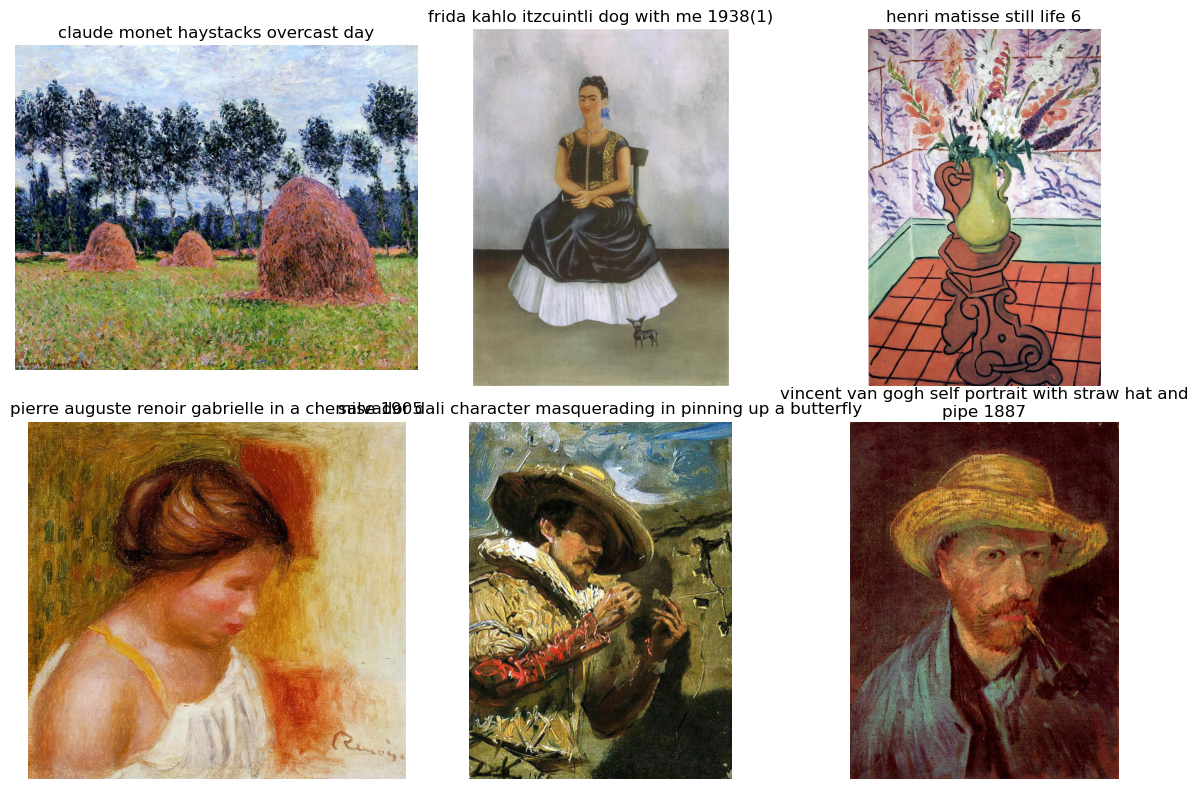

In [2]:
#Cargar y mostrar imagenes
data_folder = "data/images/"
extension = ".jpg"
files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(extension)]

cols = 3
rows = int(np.ceil(len(files) / cols))
plt.figure(figsize=(12, 4 * rows))
for i, p in enumerate(files, 1):
    img_name = os.path.basename(p).replace("_", " ").replace("-", " ").replace(".jpg", "")
    img = Image.open(p)
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name, wrap=True)
plt.tight_layout()
plt.show()

#### 2. Preparación de las imágenes para el entrenamiento y prueba del modelo. ####
Para este paso construir un pipeline que integre las transformaciones que se consideren adecuadas.

In [3]:
# Funciones para carga, redminsionamiento y transformación de imaganes y el pipeline de pre-procesamiento
def load_rgb(path: str) -> np.ndarray:
    """
    Carga una imagen desde un archivo y la convierte al espacio de color RGB.
    
    Parámetros
    ----------
    path : str

        Ruta completa o relativa al archivo de imagen a cargar.
    
    Retorna
    -------
    np.ndarray
        Array 3D de forma (altura, ancho, 3) que representa la imagen en formato RGB.
    """
    img = Image.open(path).convert("RGB")
    return np.array(img, dtype=np.uint8)


def resize_rgb(img: np.ndarray, max_side: int = MAX_SIDE) -> np.ndarray:
    """
    Redimensiona una imagen RGB manteniendo su relación de aspecto.
    
    Parámetros
    ----------
    img : np.ndarray
        Imagen RGB de entrada con forma (altura, ancho, 3) y tipo uint8.
    max_side : int, opcional
        Tamaño máximo en píxeles para el lado más largo de la imagen.
        Por defecto usa la constante global MAX_SIDE.
    
    Retorna
    -------
    np.ndarray
        Imagen redimensionada de forma (nueva_altura, nuevo_ancho, 3) como uint8.
        Si no requiere redimensionamiento, retorna la imagen original.
    """
    h, w, _ = img.shape
    scale = min(1.0, max_side / max(w, h))
    
    if scale < 1.0:
        img_pil = Image.fromarray(img)
        img_resized = img_pil.resize((int(w*scale), int(h*scale)))
        return np.array(img_resized, dtype=np.uint8)
    return img


def image_to_pixel_matrix(img_uint8: np.ndarray) -> np.ndarray:
    """
    Convierte una imagen RGB en una matriz de píxeles.
    
    Parámetros
    ----------
    img_uint8 : np.ndarray
        Imagen RGB de entrada con forma (altura, ancho, 3) y tipo uint8.
    
    Retorna
    -------
    np.ndarray
        Matriz 2D de forma (n_píxeles, 3) donde n_píxeles = altura × ancho.
   
    """
    X = img_uint8.reshape(-1, 3)
    return X


def load_and_process_image_pipeline(path: str, max_side: int = MAX_SIDE) -> tuple[np.ndarray, np.ndarray]:
    """
    Pipeline completo de preprocesamiento de imágenes para análisis de clustering.
    
    Ejecuta una secuencia de transformaciones sobre una imagen: carga desde disco,
    redimensionamiento manteniendo relación de aspecto, y conversión a matriz de píxeles.
    Este pipeline prepara la imagen para ser analizada por algoritmos de agrupación.
    
    Parámetros
    ----------
    path : str
        Ruta al archivo de imagen a procesar.
    max_side : int, opcional
        Tamaño máximo en píxeles para el lado más largo de la imagen.
        Por defecto usa la constante global MAX_SIDE.
    
    Retorna
    -------
    tuple[np.ndarray, np.ndarray]
        - img_resized : np.ndarray
            Imagen redimensionada de forma (altura, ancho, 3) como uint8.
        - pixel_matrix : np.ndarray
            Matriz de píxeles de forma (n_píxeles, 3) lista para clustering.
    """
    img = load_rgb(path)
    img_resized = resize_rgb(img, max_side=max_side)
    pixel_matrix = image_to_pixel_matrix(img_resized)
    return img_resized, pixel_matrix

3. Desarrollo del modelo de agrupación para identificar los colores dominantes en una imagen.
Construcción del modelo de agrupación con el algoritmo seleccionado con búsqueda de hiperparámetros, validándolo con medidas de evaluación adecuadas. Se justifica la selección del algoritmo y las métricas empleadas. Importante: el número de grupos debe ajustarse a las características de las imágenes, es un valor que varía, no es fijo. Es decir, el método debe construir un modelo de agrupación para cada imagen de entrada.

- Para este paso se implementó el algoritmo KMeans, con búsqueda de hiperparámetros a través de la función `hyperparameter_search`, validando los resultados con las métricas de evaluación: silhouette score, calinski harabasz score y davies bouldin score. La selección de estos algoritmos se justifica por su eficacia en la identificación de grupos en conjuntos de datos con características similares a las presentes en las imágenes, así como por su capacidad para manejar grandes volúmenes de datos de manera eficiente. Las métricas seleccionadas permiten evaluar la calidad de los agrupamientos generados, proporcionando una visión integral de la cohesión y separación de los grupos identificados.
- 

In [23]:
# Funciones para búsqueda de hiperparámetros, visualización de métricas y pipeline de análisis
def hyperparameter_search(pixel_matrix: np.ndarray, model_name: str, k_min: int, k_max: int) -> tuple[Pipeline, dict]:
    """
    Realiza búsqueda de hiperparámetros para modelos de agrupación evaluando diferentes valores de k.
    
    Entrena modelos con distintos números de clusters y calcula métricas de evaluación para cada uno:
    método del codo (inertia), silhouette score, calinski-harabasz score y davies-bouldin score.
    
    Parámetros
    ----------
    pixel_matrix : np.ndarray
        Matriz de píxeles con forma (n_píxeles, 3) para entrenar el modelo.
    model_name : str
        Nombre del algoritmo a usar: 'kmeans' o 'affinity_propagation'.
    k_min : int
        Número mínimo de clusters a evaluar.
    k_max : int
        Número máximo de clusters a evaluar.
    
    Retorna
    -------
    tuple[Pipeline, dict]
        - Pipeline con el modelo de clustering configurado.
        - Diccionario con listas de métricas para cada valor de k evaluado.
    """
    el_scores: list = []
    sl_scores: list = []
    ch_scores: list = []
    db_scores: list = []

    if model_name == "kmeans":
        model = KMeans(random_state=RANDOM_STATE, init="k-means++", n_init=20, max_iter=300)
    elif model_name == "mini_batch_kmeans":
        model = MiniBatchKMeans(random_state=RANDOM_STATE, init="k-means++", n_init=10, batch_size=4096, max_iter=200)
    else:
        raise ValueError("El nombre del modelo debe ser 'kmeans' o 'mini_batch_kmeans'")
    
    pipeline = Pipeline(steps=[("model", model)], memory="cache").set_output(transform="pandas")
    best_k = None

    for k in range(k_min, k_max + 1):
        pipeline.set_params(model__n_clusters = k)
        pipeline.fit_predict(pixel_matrix)
        
        labels = model.labels_
        el_scores.append(model.inertia_)
        sl_scores.append(silhouette_score(pixel_matrix, labels, sample_size=500, random_state=RANDOM_STATE, metric="euclidean"))
        ch_scores.append(calinski_harabasz_score(pixel_matrix, labels))
        db_scores.append(davies_bouldin_score(pixel_matrix, labels))
        if best_k is None or sl_scores[-1] > max(sl_scores[:-1]) and el_scores[-1] < min(el_scores[:-1]):
            best_k = (k, sl_scores[-1], el_scores[-1])

    return pipeline, {"elbow": el_scores, "silhouette": sl_scores, "calinski_harabasz": ch_scores, "davies_bouldin": db_scores, "best_k": best_k }


def plot_hyperparameter_search_results(results: dict, k_min: int, k_max: int, model_name: str):
    """
    Visualiza los resultados de la búsqueda de hiperparámetros en cuatro gráficas.
    
    Genera una figura con cuatro subgráficas mostrando la evolución de las métricas
    de evaluación en función del número de clusters (k).
    
    Parámetros
    ----------
    results : dict
        Diccionario con las métricas calculadas para cada k.
    k_min : int
        Valor mínimo de k evaluado.
    k_max : int
        Valor máximo de k evaluado.
    model_name : str
        Nombre del modelo para mostrar en los títulos de las gráficas.
    """
    ks = list(range(k_min, k_max + 1))
    x_label = "Número de Grupos (k)"
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(ks, results["elbow"], marker='o')
    plt.title(f"{model_name} - Elbow Method")
    plt.xlabel(x_label)
    plt.ylabel("Inertia")
    plt.grid()
    
    plt.subplot(2, 2, 2)
    plt.plot(ks, results["silhouette"], marker='o')
    plt.title(f"{model_name} - Silhouette Score")
    plt.xlabel(x_label)
    plt.ylabel("Silhouette Score")
    plt.grid()
    
    plt.subplot(2, 2, 3)
    plt.plot(ks, results["calinski_harabasz"], marker='o')
    plt.title(f"{model_name} - Calinski-Harabasz Score")
    plt.xlabel(x_label)
    plt.ylabel("Calinski-Harabasz Score")
    plt.grid()
    
    plt.subplot(2, 2, 4)
    plt.plot(ks, results["davies_bouldin"], marker='o')
    plt.title(f"{model_name} - Davies-Bouldin Score")
    plt.xlabel(x_label)
    plt.ylabel("Davies-Bouldin Score")
    plt.grid()
    
    plt.tight_layout()
    plt.show()


def pre_processing_analysis_pipeline(file_path: str, model_name: str, k_min: int, k_max: int, max_side: int = MAX_SIDE) -> tuple[Pipeline, np.ndarray, np.ndarray]:
    """
    Pipeline completo que carga, procesa una imagen y realiza búsqueda de hiperparámetros.
    
    Integra el preprocesamiento de la imagen con la búsqueda de hiperparámetros y
    visualización de métricas para determinar el número óptimo de clusters.
    
    Parámetros
    ----------
    file_path : str
        Ruta al archivo de imagen a procesar.
    model_name : str
        Nombre del algoritmo de clustering a utilizar.
    k_min : int
        Número mínimo de clusters a evaluar.
    k_max : int
        Número máximo de clusters a evaluar.
    max_side : int, opcional
        Tamaño máximo en píxeles para el lado más largo de la imagen.
        Por defecto usa la constante global MAX_SIDE.
    
    Retorna
    -------
    tuple[Pipeline, np.ndarray, np.ndarray]
        - Pipeline entrenado con el modelo de clustering.
        - Imagen redimensionada de forma (altura, ancho, 3).
        - Matriz de píxeles de forma (n_píxeles, 3).
    """
    image_resized, pixel_matrix = load_and_process_image_pipeline(file_path, max_side=max_side)
    pipeline, hiperparameter_results = hyperparameter_search(pixel_matrix, model_name, k_min, k_max)
    print(f"Mejor k encontrado: {hiperparameter_results['best_k'][0]} con Silhouette Score: {hiperparameter_results['best_k'][1]:.4f} y Elbow Score: {hiperparameter_results['best_k'][2]:.4f}")
    plot_hyperparameter_search_results(hiperparameter_results, k_min, k_max, pipeline.get_params()["model"].__class__.__name__)
    return pipeline, image_resized, pixel_matrix

In [5]:
# Funciones para extracción de paleta, reducción de imagen y visualización comparativa
def extract_color_palette(pixel_matrix: np.ndarray, pipeline: Pipeline, k: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Extrae la paleta de colores y las etiquetas de cluster entrenando el modelo con k clusters.
    
    Entrena el modelo de clustering con el número especificado de clusters y extrae
    los colores representativos (centroides) y las etiquetas de cada píxel.
    
    Parámetros
    ----------
    pixel_matrix : np.ndarray
        Matriz de píxeles con forma (n_píxeles, 3).
    pipeline : Pipeline
        Pipeline de sklearn con el modelo de clustering configurado.
    k : int
        Número de clusters a utilizar.
    
    Retorna
    -------
    tuple[np.ndarray, np.ndarray]
        - Etiquetas de cluster para cada píxel.
        - Paleta de colores (centroides) de forma (k, 3) como uint8.
    """
    pipeline.set_params(model__n_clusters = k)
    pipeline.fit_predict(pixel_matrix)
    
    return pipeline.get_params()["model"].labels_, pipeline.get_params()["model"].cluster_centers_.astype(np.uint8)


def plot_color_palette(palette: np.ndarray, title: str):
    """
    Visualiza la paleta de colores extraída como una barra horizontal.
    
    Muestra los colores dominantes identificados en formato de barra horizontal
    para facilitar su visualización y análisis.
    
    Parámetros
    ----------
    palette : np.ndarray
        Array de colores RGB de forma (k, 3).
    title : str
        Título de la visualización.
    """
    plt.figure(figsize=(4, 2))
    plt.imshow([palette], aspect='auto')
    plt.axis('off')
    plt.title(title)
    plt.show()


def image_reduction(img_resized: np.ndarray, labels: np.ndarray, color_palette: np.ndarray) -> np.ndarray:
    """
    Reconstruye la imagen utilizando únicamente los colores de la paleta extraída.
    
    Reemplaza cada píxel de la imagen original por el color del centroide de su cluster,
    creando una versión segmentada con solo k colores.
    
    Parámetros
    ----------
    img_resized : np.ndarray
        Imagen original de forma (altura, ancho, 3).
    labels : np.ndarray
        Etiquetas de cluster para cada píxel.
    color_palette : np.ndarray
        Paleta de colores (centroides) de forma (k, 3).
    
    Retorna
    -------
    np.ndarray
        Imagen segmentada de forma (altura, ancho, 3) como uint8.
    """
    new_img = color_palette[labels].reshape(img_resized.shape)
    return new_img.astype(np.uint8)


def plot_image_comparison(img_resized: np.ndarray, img_segmented: np.ndarray):
    """
    Visualiza lado a lado la imagen original y la imagen segmentada.
    
    Crea una comparación visual entre la imagen original y su versión segmentada
    con la paleta de colores extraída.
    
    Parámetros
    ----------
    img_resized : np.ndarray
        Imagen original de forma (altura, ancho, 3).
    img_segmented : np.ndarray
        Imagen segmentada de forma (altura, ancho, 3).
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title("Imagen Original")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(img_segmented)
    plt.title("Imagen segmentada")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def post_processing_pipeline(pipeline: Pipeline, img_resized: np.ndarray, pixel_matrix: np.ndarray, k: int) -> np.ndarray:
    """
    Pipeline de post-procesamiento para extracción y visualización de la paleta de colores.
    
    Ejecuta el proceso completo de extracción de paleta, reducción de imagen y visualización
    comparativa entre la imagen original y segmentada.
    
    Parámetros
    ----------
    pipeline : Pipeline
        Pipeline con el modelo de clustering entrenado.
    img_resized : np.ndarray
        Imagen redimensionada de forma (altura, ancho, 3).
    pixel_matrix : np.ndarray
        Matriz de píxeles de forma (n_píxeles, 3).
    k : int
        Número de colores en la paleta final.
    
    Retorna
    -------
    np.ndarray
        Imagen segmentada con k colores de forma (altura, ancho, 3).
    """
    labels, color_palette = extract_color_palette(pixel_matrix, pipeline, k)
    plot_color_palette(color_palette, f"Paleta de Colores - {pipeline.get_params()['model'].__class__.__name__}")
    img_segmented = image_reduction(img_resized, labels, color_palette)
    plot_image_comparison(img_resized, img_segmented)
    return img_segmented


In [6]:
# Funciones para análisis de distribución de colores en 2D mediante reducción dimensional
def color_distribution_dataframe(img_resized: np.ndarray) -> pd.DataFrame:
    """
    Genera un DataFrame con la distribución de colores proyectada en 2 dimensiones.
    
    Aplica PCA para reducir a 3 componentes y luego t-SNE para reducir a 2 dimensiones,
    creando una representación bidimensional de la distribución de colores de la imagen.
    
    Parámetros
    ----------
    img_resized : np.ndarray
        Imagen redimensionada de forma (altura, ancho, 3).
    
    Retorna
    -------
    pd.DataFrame
        DataFrame con 2 columnas representando las coordenadas x e y de cada píxel
        en el espacio 2D de la distribución de colores.
    """
    pixels_array = img_resized.reshape(-1, 3).astype(np.float64)

    pca = PCA(n_components=3)
    img_pca = pca.fit_transform(pixels_array)

    tsne = TSNE(random_state=RANDOM_STATE, verbose=1, perplexity=3, n_components=2, max_iter=250)
    return pd.DataFrame(tsne.fit_transform(img_pca))    


def plot_color_distribution(data_frame: pd.DataFrame):
    """
    Visualiza la distribución de colores en un gráfico de dispersión 2D.
    
    Crea un scatter plot que muestra la distribución espacial de los colores
    de una imagen en un espacio bidimensional reducido.
    
    Parámetros
    ----------
    data_frame : pd.DataFrame
        DataFrame con coordenadas x e y (columnas 0 y 1) para cada punto.
    """
    plt.scatter(data_frame[0], data_frame[1], alpha=0.8, s=5)
    plt.title("Distribución de Colores en 2D")
    plt.show()


def color_distribution(img_resized: np.ndarray):
    """
    Pipeline completo para generar y visualizar la distribución de colores en 2D.
    
    Combina la reducción dimensional y visualización para crear un gráfico
    de la distribución espacial de colores de una imagen.
    
    Parámetros
    ----------
    img_resized : np.ndarray
        Imagen redimensionada de forma (altura, ancho, 3).
    """
    df = color_distribution_dataframe(img_resized)
    plot_color_distribution(df)

- A continuación se muestra un ejemplo de la aplicación del método para una de las imágenes seleccionadas. Primero se carga la imagen, se procesa y se realiza la búsqueda de hiperparámetros para el algoritmo KMeans. Luego se visualizan los resultados obtenidos.

Analizando imagen: claude-monet_haystacks-overcast-day.jpg
Mejor k encontrado: 2 con Silhouette Score: 0.5521 y Elbow Score: 1031977489.9150


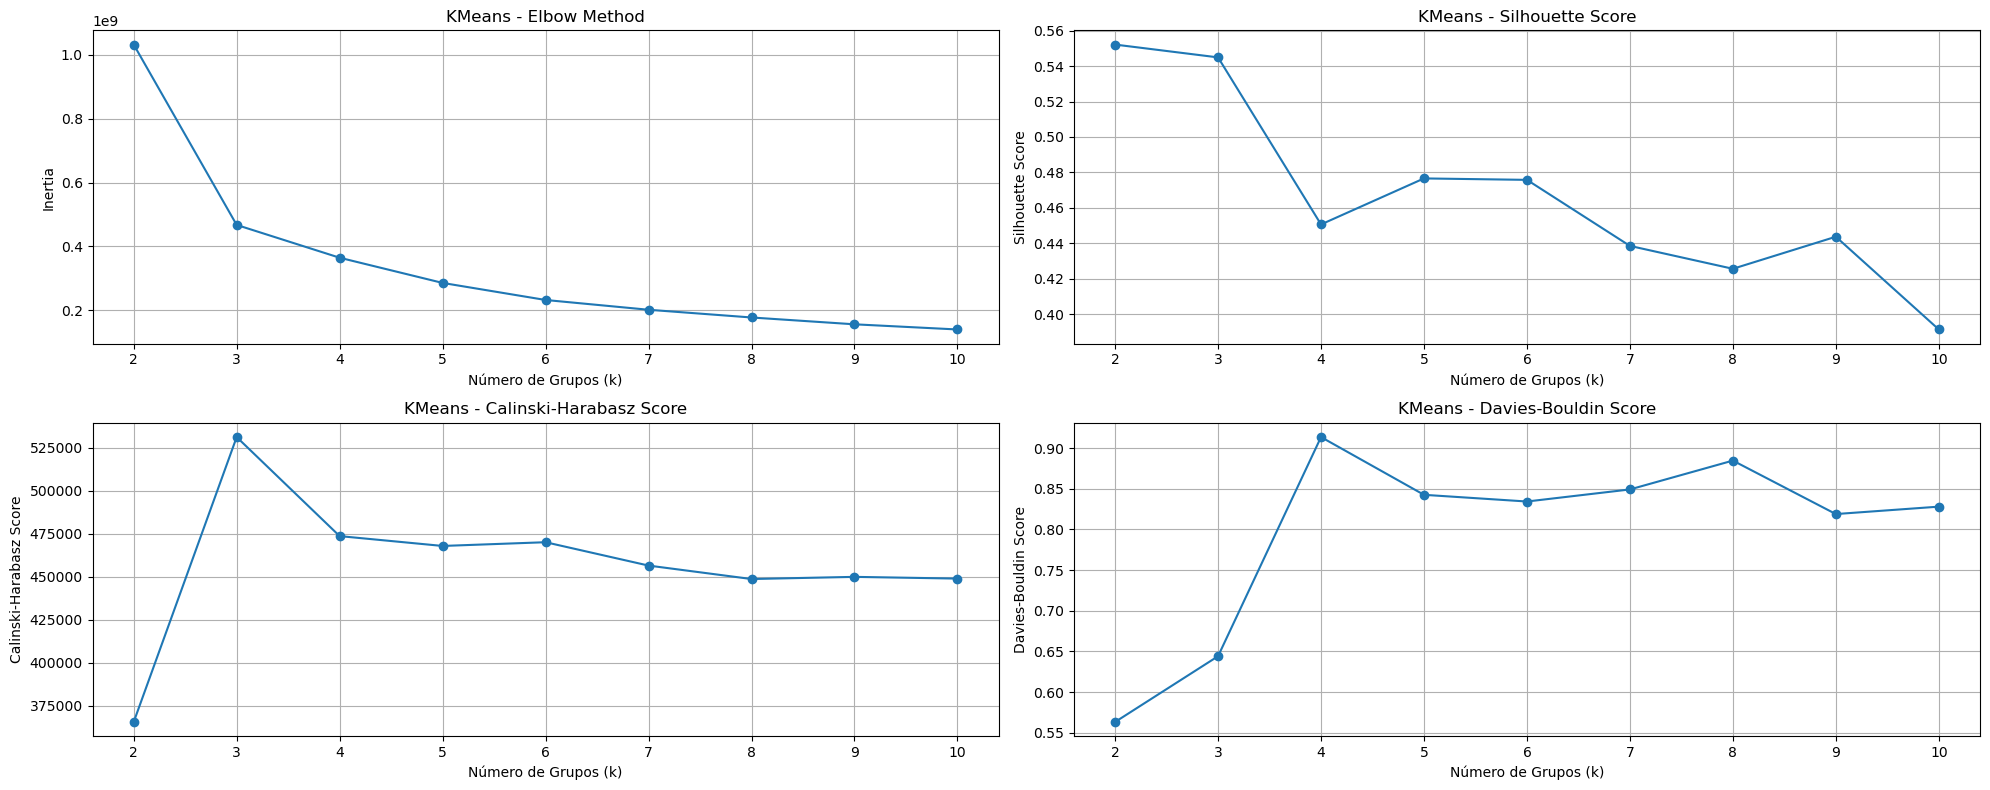

Mejor k encontrado: 2 con Silhouette Score: 0.5530 y Elbow Score: 1032108722.4464


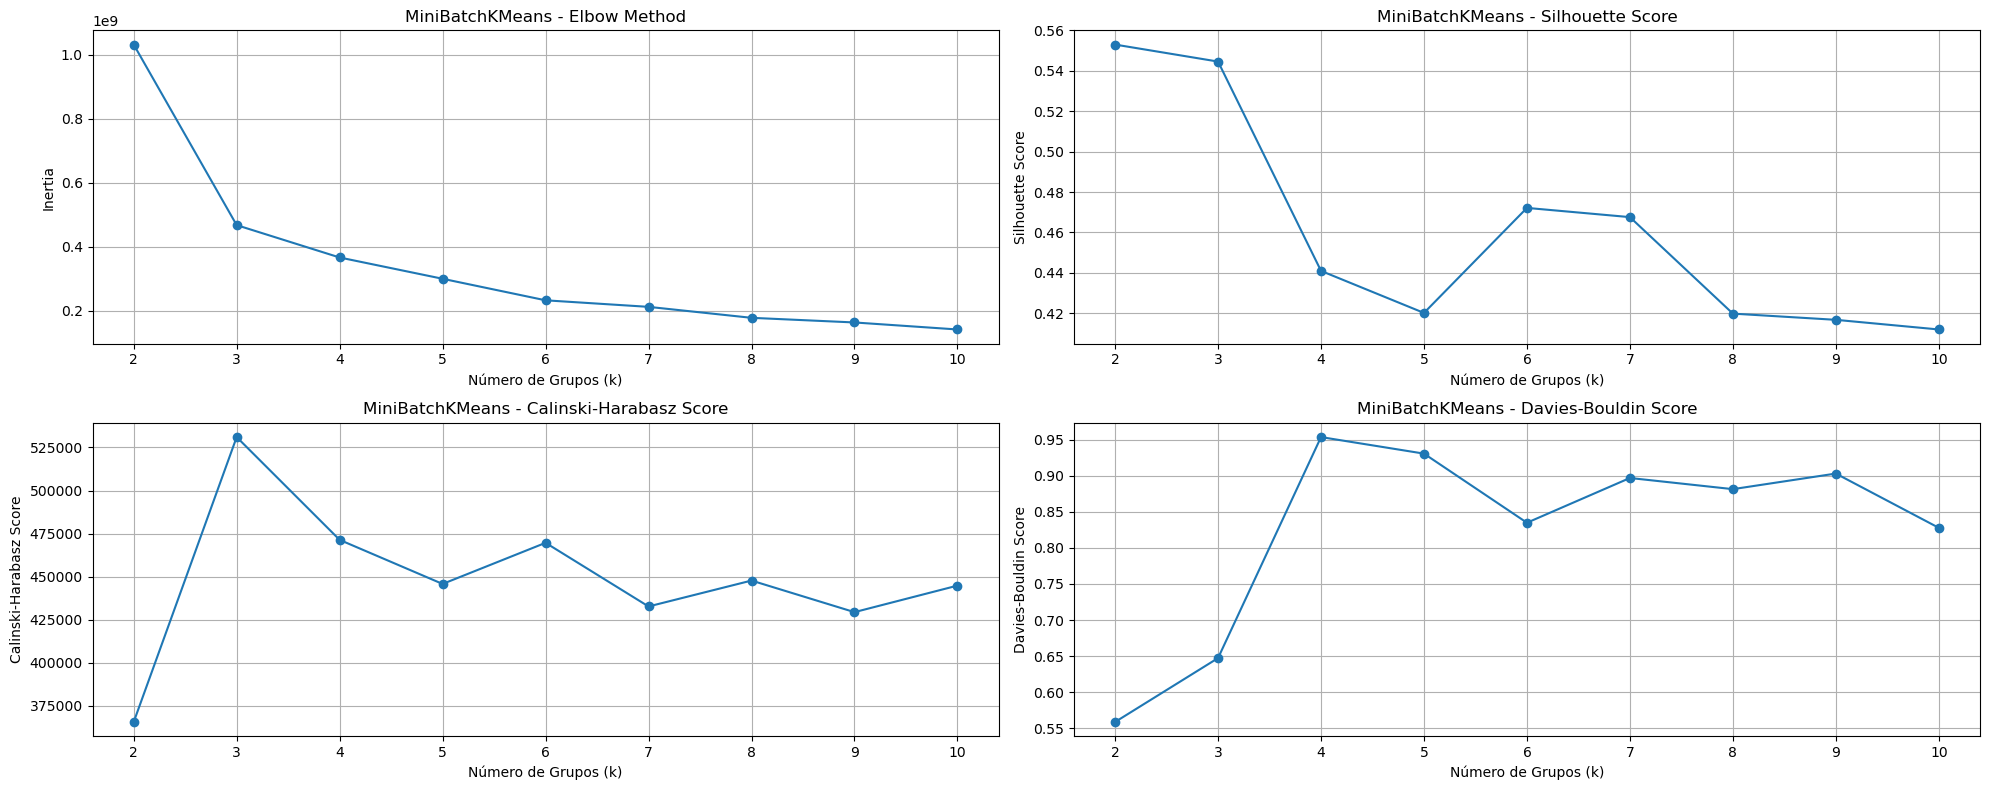

In [27]:
index = 0
file_path = files[index]
print(f"Analizando imagen: {os.path.basename(file_path)}")
#pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 15, 1024)
#pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 15, 512)
#pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 15, 256)
pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 10)
pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "mini_batch_kmeans", 2, 10)


- Para la imagen seleccionada, el método identificó que el número óptimo de grupos es 4, lo que indica que hay cuatro colores dominantes presentes en la imagen. La paleta de colores generada a partir de estos grupos muestra los tonos más representativos, lo que puede ser útil para diversas aplicaciones creativas y analíticas.

- Una vez seleccionado el número óptimo de grupos, se ejecuta el proceso de agrupación para el K seleccionado para luego mostrar la paleta de colores generada a partir de los grupos identificados, por el algoritmo.


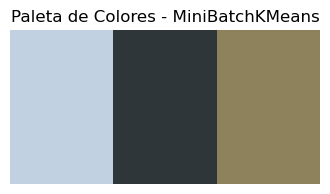

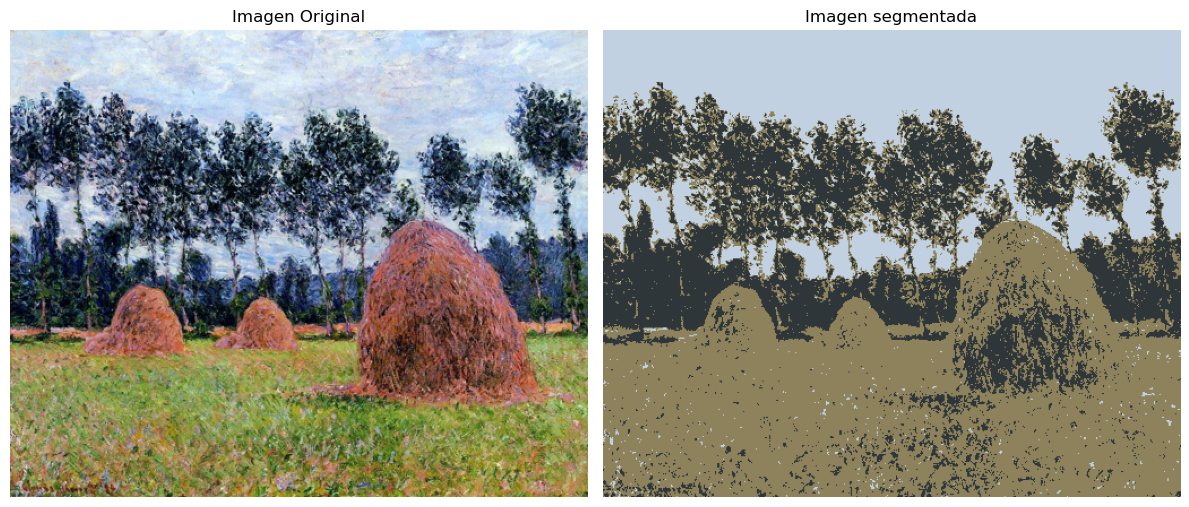

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 211043 samples in 0.834s...
[t-SNE] Computed neighbors for 211043 samples in 2.782s...
[t-SNE] Computed conditional probabilities for sample 1000 / 211043
[t-SNE] Computed conditional probabilities for sample 2000 / 211043
[t-SNE] Computed conditional probabilities for sample 3000 / 211043
[t-SNE] Computed conditional probabilities for sample 4000 / 211043
[t-SNE] Computed conditional probabilities for sample 5000 / 211043
[t-SNE] Computed conditional probabilities for sample 6000 / 211043
[t-SNE] Computed conditional probabilities for sample 7000 / 211043
[t-SNE] Computed conditional probabilities for sample 8000 / 211043
[t-SNE] Computed conditional probabilities for sample 9000 / 211043
[t-SNE] Computed conditional probabilities for sample 10000 / 211043
[t-SNE] Computed conditional probabilities for sample 11000 / 211043
[t-SNE] Computed conditional probabilities for sample 12000 / 211043
[t-SNE] Computed conditional probabi

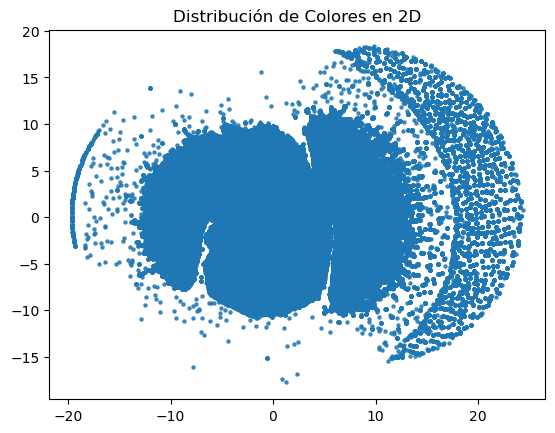

In [28]:
post_processing_pipeline(pipeline, img_resized, pixel_matrix, 3)
color_distribution(img_resized)

Analizando imagen: frida-kahlo_itzcuintli-dog-with-me-1938(1).jpg
Mejor k encontrado: 3 con Silhouette Score: 0.6369 y Elbow Score: 160337660.3734


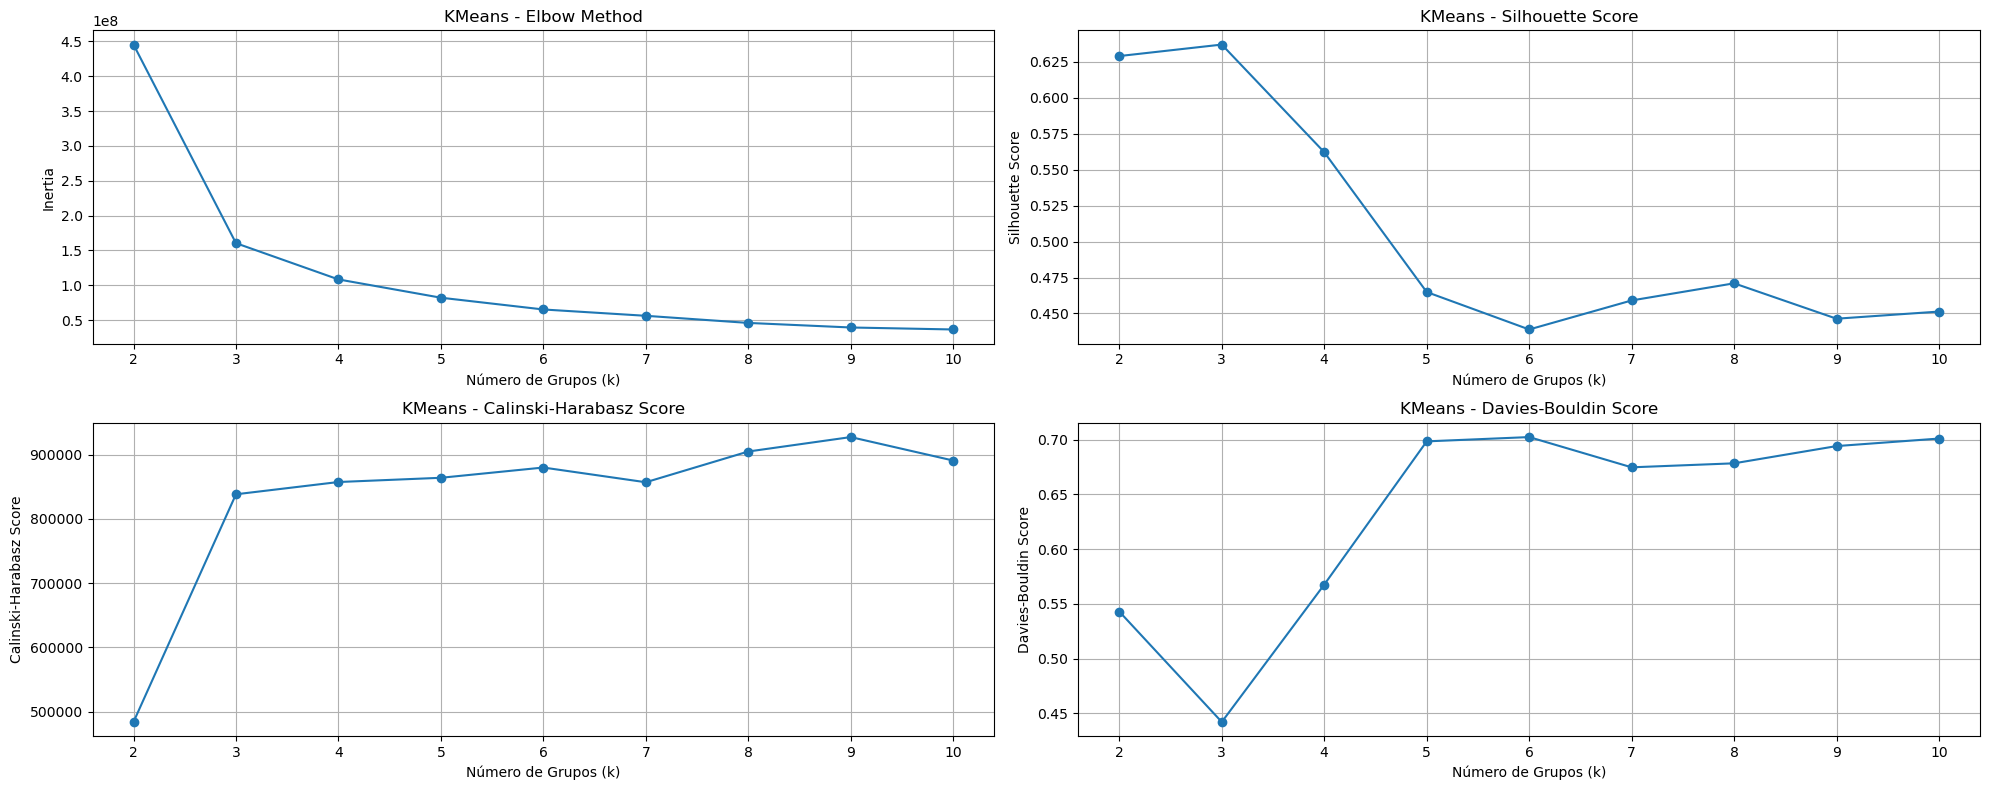

In [9]:
index = 1
file_path = files[index]
print(f"Analizando imagen: {os.path.basename(file_path)}")
#pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 10, 1024)
#pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 10, 512)
#pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 10, 256)
pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 10)

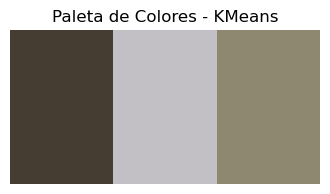

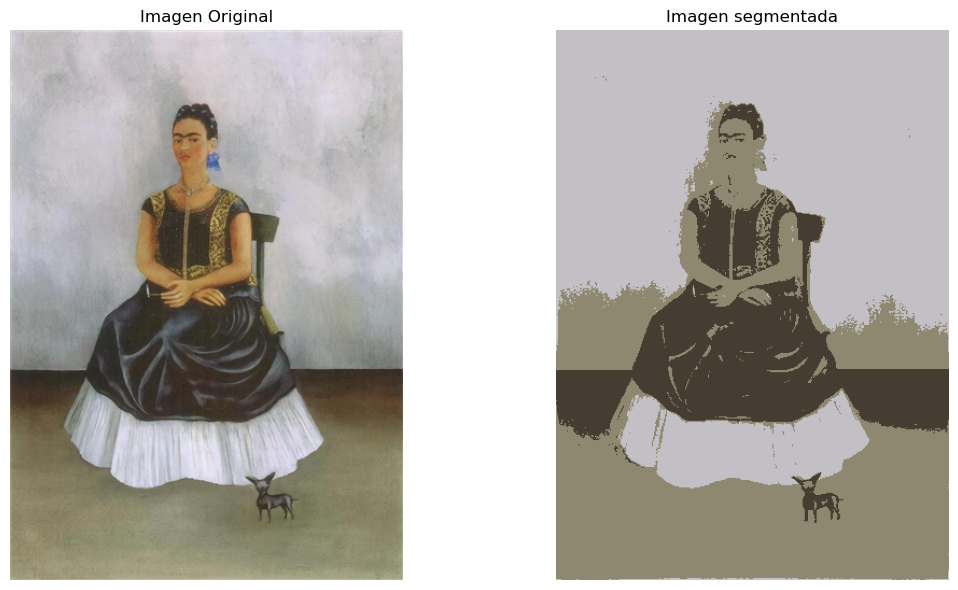

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 186515 samples in 0.215s...
[t-SNE] Computed neighbors for 186515 samples in 1.600s...
[t-SNE] Computed conditional probabilities for sample 1000 / 186515
[t-SNE] Computed conditional probabilities for sample 2000 / 186515
[t-SNE] Computed conditional probabilities for sample 3000 / 186515
[t-SNE] Computed conditional probabilities for sample 4000 / 186515
[t-SNE] Computed conditional probabilities for sample 5000 / 186515
[t-SNE] Computed conditional probabilities for sample 6000 / 186515
[t-SNE] Computed conditional probabilities for sample 7000 / 186515
[t-SNE] Computed conditional probabilities for sample 8000 / 186515
[t-SNE] Computed conditional probabilities for sample 9000 / 186515
[t-SNE] Computed conditional probabilities for sample 10000 / 186515
[t-SNE] Computed conditional probabilities for sample 11000 / 186515
[t-SNE] Computed conditional probabilities for sample 12000 / 186515
[t-SNE] Computed conditional probabi

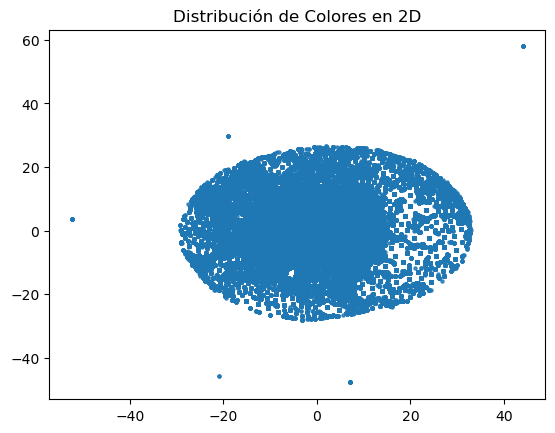

In [10]:
post_processing_pipeline(pipeline, img_resized, pixel_matrix, 3)
color_distribution(img_resized)

Analizando imagen: pierre-auguste-renoir_gabrielle-in-a-chemise-1905.jpg
Mejor k encontrado: 2 con Silhouette Score: 0.6083 y Elbow Score: 720918750.8493


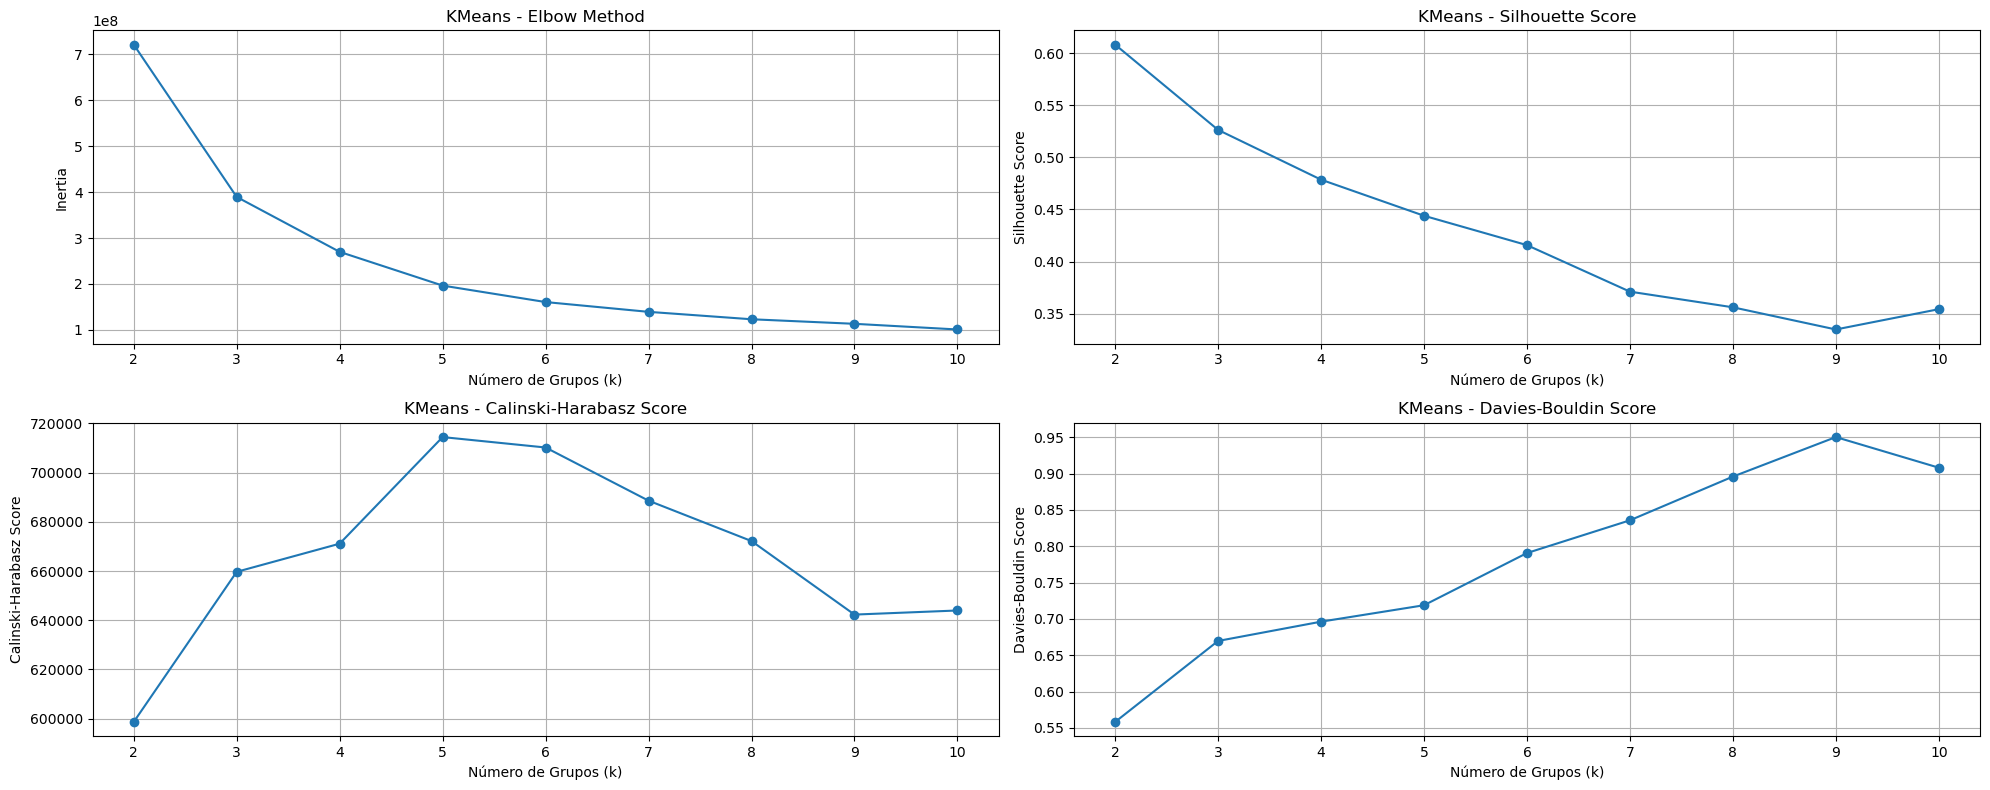

In [11]:
index = 3
file_path = files[index]
print(f"Analizando imagen: {os.path.basename(file_path)}"   )
#pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 10, 1024)
#pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 10, 512)
#pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 10, 256)
pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 10)

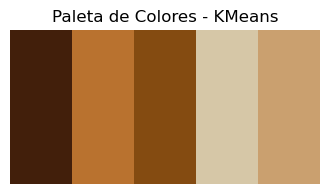

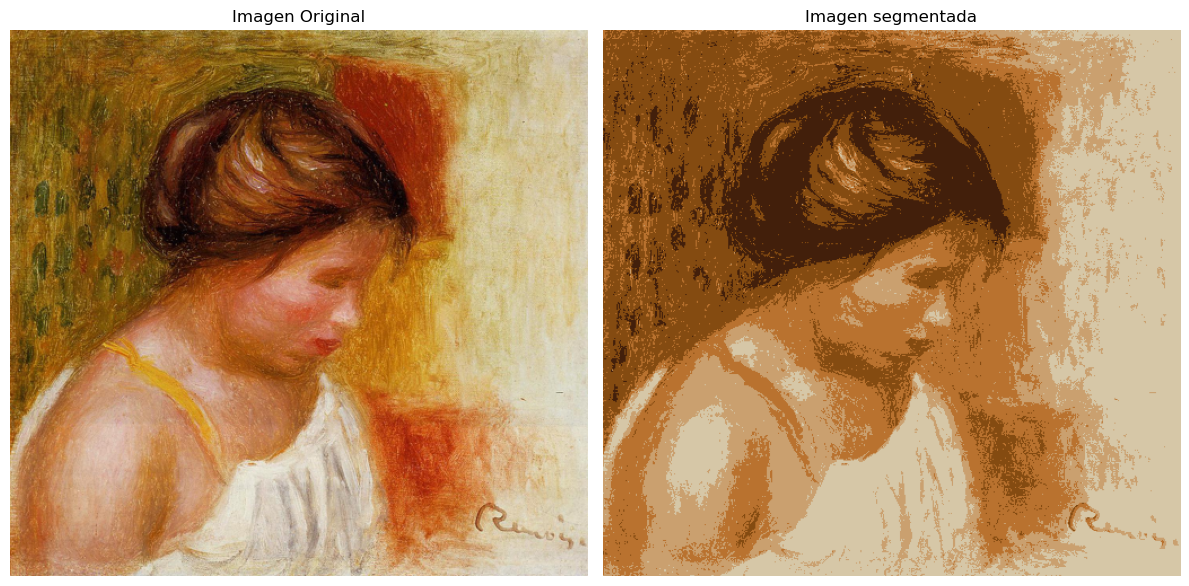

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 247808 samples in 0.379s...
[t-SNE] Computed neighbors for 247808 samples in 2.857s...
[t-SNE] Computed conditional probabilities for sample 1000 / 247808
[t-SNE] Computed conditional probabilities for sample 2000 / 247808
[t-SNE] Computed conditional probabilities for sample 3000 / 247808
[t-SNE] Computed conditional probabilities for sample 4000 / 247808
[t-SNE] Computed conditional probabilities for sample 5000 / 247808
[t-SNE] Computed conditional probabilities for sample 6000 / 247808
[t-SNE] Computed conditional probabilities for sample 7000 / 247808
[t-SNE] Computed conditional probabilities for sample 8000 / 247808
[t-SNE] Computed conditional probabilities for sample 9000 / 247808
[t-SNE] Computed conditional probabilities for sample 10000 / 247808
[t-SNE] Computed conditional probabilities for sample 11000 / 247808
[t-SNE] Computed conditional probabilities for sample 12000 / 247808
[t-SNE] Computed conditional probabi

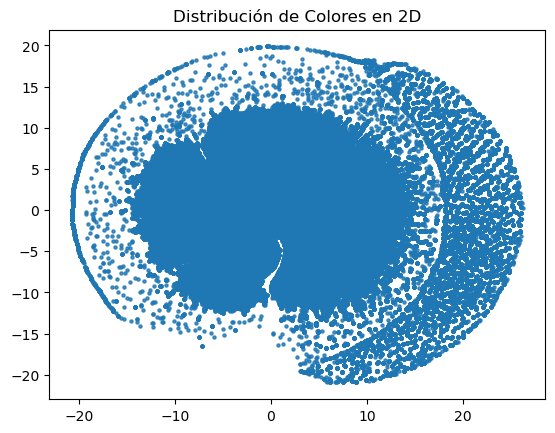

In [12]:
post_processing_pipeline(pipeline, img_resized, pixel_matrix, 5)
color_distribution(img_resized)

Analizando imagen: salvador-dali_character-masquerading-in-pinning-up-a-butterfly.jpg
Mejor k encontrado: 2 con Silhouette Score: 0.5477 y Elbow Score: 669073294.5549


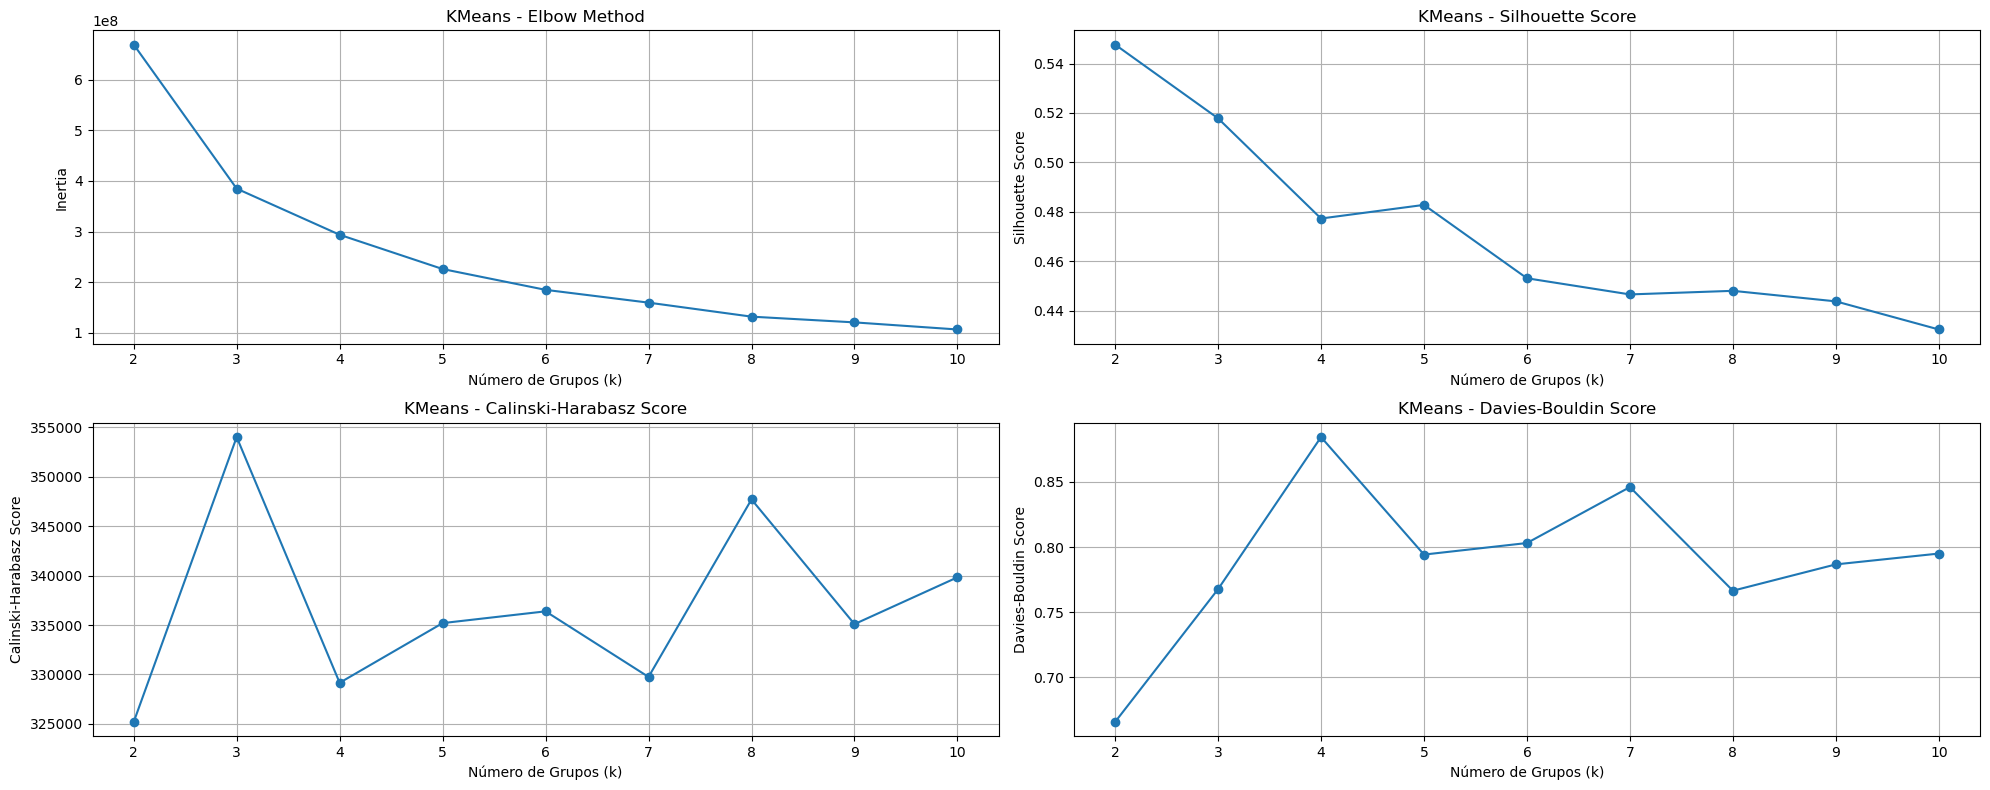

In [13]:
index = 4
file_path = files[index]
print(f"Analizando imagen: {os.path.basename(file_path)}"   )
pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 10)

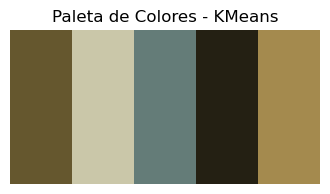

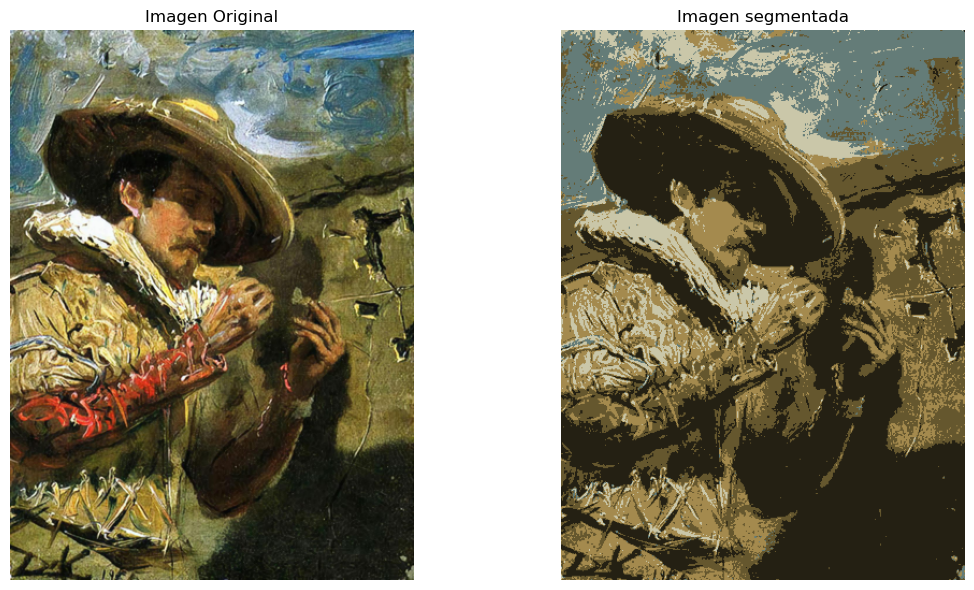

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 192512 samples in 0.394s...
[t-SNE] Computed neighbors for 192512 samples in 2.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 192512
[t-SNE] Computed conditional probabilities for sample 2000 / 192512
[t-SNE] Computed conditional probabilities for sample 3000 / 192512
[t-SNE] Computed conditional probabilities for sample 4000 / 192512
[t-SNE] Computed conditional probabilities for sample 5000 / 192512
[t-SNE] Computed conditional probabilities for sample 6000 / 192512
[t-SNE] Computed conditional probabilities for sample 7000 / 192512
[t-SNE] Computed conditional probabilities for sample 8000 / 192512
[t-SNE] Computed conditional probabilities for sample 9000 / 192512
[t-SNE] Computed conditional probabilities for sample 10000 / 192512
[t-SNE] Computed conditional probabilities for sample 11000 / 192512
[t-SNE] Computed conditional probabilities for sample 12000 / 192512
[t-SNE] Computed conditional probabi

KeyboardInterrupt: 

In [14]:
post_processing_pipeline(pipeline, img_resized, pixel_matrix, 5)
color_distribution(img_resized)